In [1]:
import numpy as np
import pandas as pd
from pyscheduling.FS import FmCmax, FlowShop
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import random
import numpy as np

## Makespan

In [2]:
def compute_makespan(schedule, p):
    _, m = p.shape
    n = len(schedule)
    c = [[0]*m for i in range(n)]
    for i in range(n):
        for j in range(m):
            if i == 0 and j == 0:
                c[i][j] = p[schedule[i]][j]
            elif i == 0:
                c[i][j] = c[i][j-1] + p[schedule[i]][j]
            elif j == 0:
                c[i][j] = c[i-1][j] + p[schedule[i]][j]
            else:
                c[i][j] = max(c[i][j-1], c[i-1][j]) + p[schedule[i]][j]
    return c[n-1][m-1]

In [6]:
def heuristique_NEH(M):
    n , m = M.shape
    p = M.copy()

    # Step 1: Compute the processing time of each job
    processing_time = [sum(p[i]) for i in range(n)]

    # Step 2: Sort the jobs in decreasing order of processing time
    sorted_jobs = sorted(range(n), key=lambda i: processing_time[i], reverse=True)

    # Step 3: Initialize the schedule with the first job
    schedule = [sorted_jobs[0]]

    # Step 4: Insert each subsequent job into the schedule in a position that minimizes the makespan
    for i in range(1, n):
        best_pos = -1
        best_makespan = float('inf')
        for j in range(len(schedule)+1):
            temp_schedule = schedule[:j] + [sorted_jobs[i]] + schedule[j:]
            temp_makespan = compute_makespan(temp_schedule, p)
            if temp_makespan < best_makespan:
                best_makespan = temp_makespan
                best_pos = j
        schedule.insert(best_pos, sorted_jobs[i])

    return schedule, compute_makespan(schedule, p)


def johnson_method(processing_times):
    
    jobs, machines = processing_times.shape
    #print(jobs,machines)
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        # Delete the job appended
    return m1+m2



def heuristique_CDS(M):
    m = M.shape[1]
    solutions = []
    makespans = []

    for k in range(1,m):
        P1 = M[:,0:k].sum(axis=1) # sommer les durées sur les k premières machines
        P2 = M[:,m-k:m].sum(axis=1) # sommer les durées sur les m-k dernières machines
        P1_P2 = np.hstack([P1[:,None],P2[:,None]]) # créer une matrice à deux colonnes avec P1 et P2

        johnson_seq = johnson_method(P1_P2) # appliquer la méthode de Johnson sur P1_P2

        solutions.append(johnson_seq)
        makespans.append(np.apply_along_axis(compute_makespan, 0, johnson_seq, M)) # calculer le makespan de v avec M

    score = np.min(makespans) # trouver le score minimal
    return solutions[np.argmin(makespans)], score # renvoyer la solution correspondant au score minimal


# permutation 
def swap_perturb(schedule):
    schedule=list(schedule)
    i, j = random.sample(range(len(schedule)), 2)
    perturbed_schedule = schedule.copy()
    perturbed_schedule[i], perturbed_schedule[j] = perturbed_schedule[j], perturbed_schedule[i]
    return perturbed_schedule


def pairwise_permute_n(schedule, n_perturb):
    """
    Performs n random pairwise permutations between elements in a list.
    
    """
    new_schedule = schedule.copy()
    for i in range(n_perturb):
        idx1, idx2 = random.sample(range(len(new_schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
    return new_schedule

def perform_insert(schedule, i, j):
    """
    Performs an INSERT move on the given permutation by moving the job at
    position i to position j.
    
     - i: the position of the job to be moved.
     - j: the position where the job should be inserted.
    """
    schedule=list(schedule)
    new_schedule = schedule.copy()
    job = new_schedule.pop(i)
    new_schedule.insert(j, job)
    return new_schedule



def ils(schedule,processing_times,max_iter,n_perturb):
    n_jobs , n_machines = processing_times.shape
    cnt=0
    schedule=list(schedule)
    schedule_best=schedule.copy()
    
    for itr in range(max_iter):
        for j in range(n_jobs):
            
            #selecting the k
            k=schedule.index(schedule_best[j])#step 5 of the algorithm
            obj = 0
            schedule_optim=schedule.copy()
            for e in range(n_jobs):
                if (k!=e) :
                    new_schedule=perform_insert(schedule, k, e)
                    new_obj = compute_makespan(new_schedule, processing_times)
                    if(new_obj<obj):
                        schedule_optim=new_schedule.copy()
                        obj = new_obj

            #step 7
            if(compute_makespan(schedule_optim, processing_times)<compute_makespan(schedule, processing_times)):
                schedule=schedule_optim.copy()
                cnt=0
            else:
                cnt=cnt+1

            if(compute_makespan(schedule, processing_times)<compute_makespan(schedule_best, processing_times)):
                schedule_best=schedule.copy()

            if(cnt>=n_jobs):
                ss=pairwise_permute_n(schedule_best, n_perturb)
                if(compute_makespan(ss, processing_times)<compute_makespan(schedule_best, processing_times)):
                    schedule_best=ss.copy()
                cnt=0
    return schedule_best


def local_search(schedule, processing_times):
    num_jobs,num_machines=processing_times.shape
    improved_schedule = schedule.copy()
    for i in range(num_jobs-2):
        for j in range(i+1, num_jobs):
            neighbor_schedule = improved_schedule.copy()
            neighbor_schedule[i], neighbor_schedule[j] = neighbor_schedule[j], neighbor_schedule[i]
            neighbor_obj = compute_makespan(neighbor_schedule, processing_times)
            if neighbor_obj < compute_makespan(improved_schedule, processing_times):
                improved_schedule = neighbor_schedule
    return improved_schedule

# **PSO-SPV**
https://sci-hub.se/10.1007/978-3-540-28646-2_38

## **Implémentation :**

In [4]:

def spv(position : list):
    """Smallest Position Value : Returns a list of the indices of the given list in increasing order."""
    seq = sorted(range(len(position)), key=lambda i: position[i])
    return seq



def get_pos(seq : list):

    # Generate a list of random numbers and sort them in ascending order
    random_numbers = sorted([random.random() for _ in range(len(seq))])

    # Sort the random numbers according to the seq using NumPy's advanced indexing
    out = np.zeros(len(seq))
    out[seq] = random_numbers
    return out 



# initial swarm : s-1 random, 1 NEH
def init_swarm2(processing_times,swarm_size,v_min,v_max):
    n_jobs=processing_times.shape[0]
    positions=[]
    velocities=[]
    best_positions=[]
    sequences=[]
    i=0
    while (i<swarm_size-1):
        pos = [random.uniform(0.0,4.0) for _ in range(n_jobs)]
        positions.append(pos)
        best_positions.append(pos)
        vel = [random.uniform(v_min,v_max) for _ in range(n_jobs)]
        velocities.append(vel)
        seq=spv(pos)
        sequences.append(seq)
        i=i+1
    seq,_ = heuristique_NEH(processing_times)
    sequences.append(seq)
    positions.append(get_pos(seq))
    best_positions.append(pos)
    vel = [random.uniform(v_min,v_max) for _ in range(n_jobs)]
    velocities.append(vel)
    return positions,velocities,best_positions,sequences

In [7]:
def pso(processing_times,c1=1,c2=2,v_min=-4,v_max=4,w=0.95,alpha=0.975,max_iter=100):
    n,m = processing_times.shape
    s=2*n
    x,v,p,seq=init_swarm2(processing_times,s,v_min,v_max)
    g=x[s-1].copy()
    new=[]
    #Main loop 
    for it in range (max_iter):
        w=w*alpha
        for i in range(s):
            for j in range(n):
                r1= random.uniform(0,1)
                r2=random.uniform(0,1)
                #update velocity
                v[i][j]=v[i][j]*w+c1*r1*(p[i][j]-x[i][j])+c2*r2*(g[j]-x[i][j])
                #update position 
                x[i][j]=x[i][j]+v[i][j]
            seq[i]=spv(x[i])
        
        #update personal best positions
        for i in range(s):
            if compute_makespan(seq[i],processing_times)<compute_makespan(spv(p[i]),processing_times) :
                p[i]=x[i].copy()
        
        #update the global best postion 
        for i in range (s):
            if compute_makespan(spv(p[i]),processing_times)<compute_makespan(spv(g),processing_times) :
                g=p[i].copy()
        
        #perform a local search on the global best solution and update it 
        new=local_search(spv(g),processing_times)
        g=get_pos(new).copy()
    return spv(g)

## **Tests et résultats :**

### 1. Paramètres à défaut :

In [8]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
n = instance.n
m = instance.m
upper_bound=1102
M = np.array(instance.P)
schedule=pso(M,max_iter=500)
print(schedule)
obj=compute_makespan(schedule,M)
print(obj)
print("instance aléatoire:",100*(obj-upper_bound)/upper_bound,"%")

[6, 3, 2, 0, 1, 8, 4, 7, 5, 9]
1104
instance aléatoire: 0.18148820326678766 %


In [9]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
for i in range(10):
    M = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule=pso(M,max_iter=500)
    obj=compute_makespan(schedule,M)
    print(obj)
    print("instance",i+1,":",100*(obj-upper_bound)/upper_bound,"%")

1286
instance 1 : 0.6259780907668232 %
1365
instance 2 : 0.44150110375275936 %
1113
instance 3 : 2.9602220166512487 %
1316
instance 4 : 1.7788089713843773 %
1243
instance 5 : 0.5663430420711975 %
1210
instance 6 : 1.2552301255230125 %
1251
instance 7 : 0.9685230024213075 %
1217
instance 8 : 0.912106135986733 %
1253
instance 9 : 1.8699186991869918 %
1151
instance 10 : 3.88086642599278 %


In [10]:
f =  open("../TP02-Heuristiques/data/Taillard3.pkl", "rb")
taillard = pickle.load(f)
for i in range(10):
    M = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule=pso(M,500,max_iter=500)
    obj=compute_makespan(schedule,M)
    print(obj)
    print("instance",i+1,":",100*(obj-upper_bound)/upper_bound,"%")

C:\Users\Dell-U\AppData\Local\Temp\ipykernel_15984\3910025672.py:15: RuntimeWarning: overflow encountered in double_scalars
  v[i][j]=v[i][j]*w+c1*r1*(p[i][j]-x[i][j])+c2*r2*(g[j]-x[i][j])
C:\Users\Dell-U\AppData\Local\Temp\ipykernel_15984\3910025672.py:15: RuntimeWarning: invalid value encountered in double_scalars
  v[i][j]=v[i][j]*w+c1*r1*(p[i][j]-x[i][j])+c2*r2*(g[j]-x[i][j])


2382
instance 1 : 3.7004788855028297 %
2150
instance 2 : 2.380952380952381 %
2334
instance 3 : 0.34393809114359414 %
2248
instance 4 : 1.1246063877642825 %
2359
instance 5 : 2.968136185072021 %
2302
instance 6 : 3.4141958670260557 %
2356
instance 7 : 3.6515618125824902 %
2233
instance 8 : 1.5 %
2309
instance 9 : 3.218596334376397 %
2252
instance 10 : 3.3976124885215793 %


### 2. Calibrage des paramètres:

### Le paramètre alpha:

C:\Users\Dell-U\AppData\Local\Temp\ipykernel_16520\3548258670.py:15: RuntimeWarning: overflow encountered in double_scalars
  v[i][j]=v[i][j]*w+c1*r1*(p[i][j]-x[i][j])+c2*r2*(g[j]-x[i][j])
C:\Users\Dell-U\AppData\Local\Temp\ipykernel_16520\3548258670.py:15: RuntimeWarning: invalid value encountered in double_scalars
  v[i][j]=v[i][j]*w+c1*r1*(p[i][j]-x[i][j])+c2*r2*(g[j]-x[i][j])


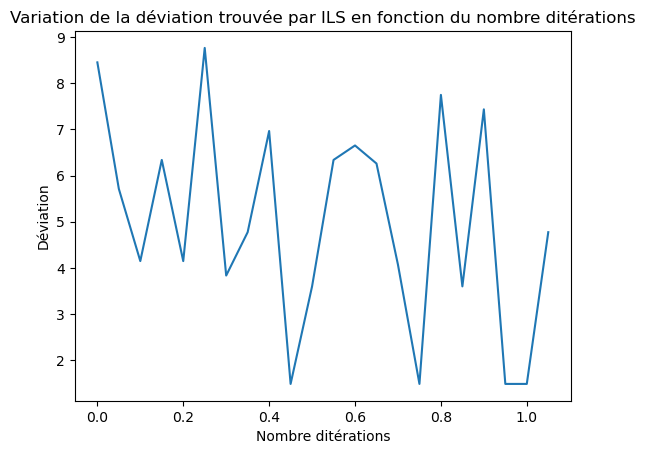

In [258]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
alpha=[]
dev=[]

for a in np.arange(0.0, 1.1, 0.05):
    alpha.append(a)
    schedule=pso(processing_times,500,w=0.9,alpha=a,max_iter=500)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(alpha, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Le paramètre w :

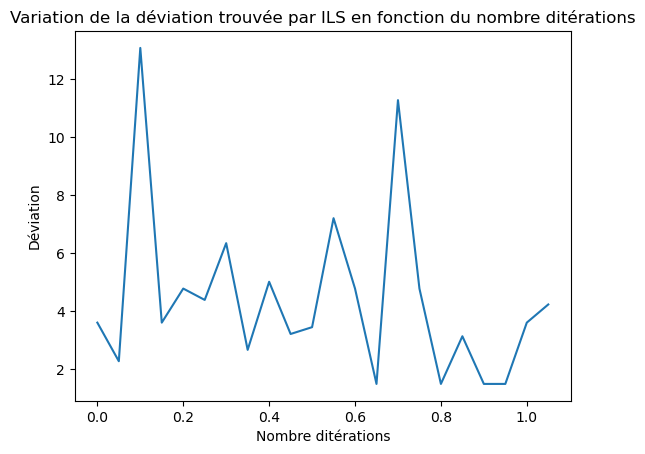

In [260]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
W=[]
dev=[]

for w in np.arange(0.0, 1.1, 0.05):
    W.append(w)
    schedule=pso(processing_times,w=w,max_iter=1000)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(W, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Le paramètre c1: 

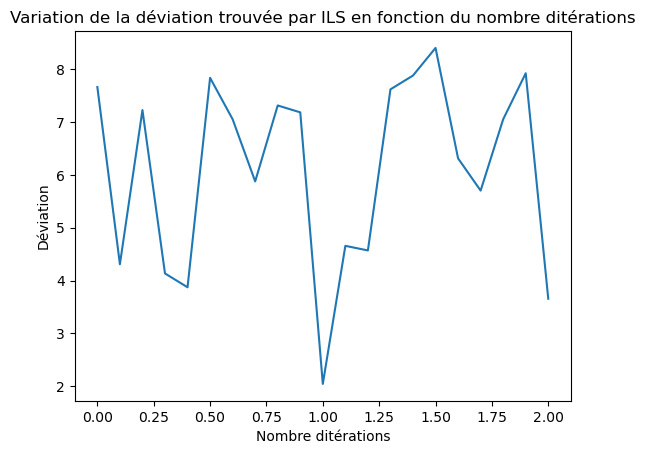

In [266]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
C=[]
dev=[]

for c in np.arange(0.0, 2.1, 0.1):
    C.append(c)
    schedule=pso(processing_times,c1=c,max_iter=1000)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(C, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Le paramètre c2 :

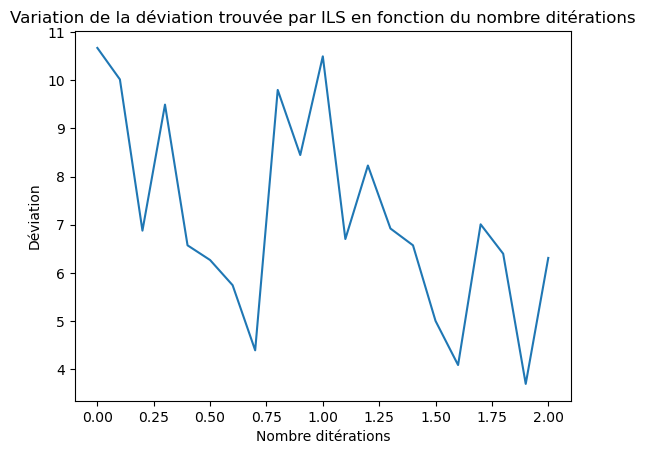

In [267]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
C=[]
dev=[]

for c in np.arange(0.0, 2.1, 0.1):
    C.append(c)
    schedule=pso(processing_times,c2=c,max_iter=100)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(C, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

# **CPSO et HCPSO**
https://www.sciencedirect.com/science/article/pii/S2288430016300161

## **Implémentation**

In [93]:

def get_positions(seq : list):
    " returns a list containing the positions of each job in the sequence 'seq'"

    pos=[]
    for j in range(len(seq)):
        pos.append(seq.index(j))
    return pos

# initial swarm : s-1 random, 1 NEH
def init_swarm(processing_times,swarm_size,v_min,v_max):
    n_jobs=processing_times.shape[0]
    positions=[]
    velocities=[]
    best_positions=[]
    ps=[]
    i=0
    while (i<swarm_size-1):
        pos = list(range(n_jobs))
        random.shuffle(pos)
        vel = [random.uniform(v_min,v_max) for _ in range(n_jobs)]
        velocities.append(vel)
        if(pos not in positions):
            ps.append(get_positions(pos))
            positions.append(pos)
            best_positions.append(pos)
            i=i+1
    pos,_ = heuristique_NEH(processing_times)
    positions.append(pos)
    best_positions.append(pos)
    ps.append(get_positions(pos))
    vel = [random.uniform(v_min,v_max) for _ in range(n_jobs)]
    velocities.append(vel)
    return positions,velocities,best_positions,ps





# generate a new feasible sequence for a position xi
def new_seq(x_i,ps_i,y_i,g,p_i,n):
    for j in range(n):
        if y_i[j]==1 : r=ps_i[g[j]]
        elif y_i[j]==-1 : r=ps_i[p_i[j]]
        else : 
            r=-1
            i=j
            while i<n:
                if x_i[i]!=p_i[j] and x_i[i]!=g[j] : 
                    r=i
                    break 
                else : i=i+1

        rand = random.uniform(0,1)
        if (r>=j) or (rand>0.5) and (r!=-1) :
            x_i[j],x_i[r]=x_i[r],x_i[j]
            ps_i[j],ps_i[r]=ps_i[r],ps_i[j]
    return x_i,ps_i



In [96]:
# def pso(processing_times,s,c1=0.8,c2=0.2,v_min=-10,v_max=10,w=0.75,alpha=0.3,beta=0.1,max_iter=10):
#     n,m = processing_times.shape
#     x,v,p,ps=init_swarm(processing_times,s,v_min,v_max)
#     y=[]
#     g=x[s-1].copy()
#     # print(compute_makespan(g,processing_times))

#     #Main loop 
#     for it in range (max_iter):

#         for i in range(s): 
#             #compute yi
#             y_i=[]
#             for j in range(n):
#                 if x[i][j]==g[j] : y_i.append(1)
#                 elif x[i][j]==p[i][j] : y_i.append(-1)
#                 elif x[i][j]==p[i][j] and x[i][j]==g[j] : 
#                     rand= random.uniform(0,1)
#                     if rand>0.5 : y_i.append(-1)
#                     else : y_i.append(1)
#                 else : y_i.append(0)
#             y.append(y_i)

#             # update velocity
#             for j in range (n):
#                 r1= random.uniform(0,1)
#                 r2=random.uniform(0,1)
#                 v[i][j]=v[i][j]*w+c1*r1*(-1-y[i][j])+c2*r2*(1-y[i][j])

#             # update position  
#             for j in range(n):
#                 #1. calculate l
#                 l=v[i][j]+y[i][j]

#                 #2. adjust the value of y
#                 if l>alpha : y[i][j]=1
#                 elif l<-alpha :  y[i][j]=-1
#                 else : y[i][j]=0

#                 #3. update the position 
#                 # if y[i][j]==1 : x[i][j]=g[j]
#                 # elif  y[i][j]==-1 : x[i][j]=p[i][j]
#                 # else : x[i][j]= random.randint(0,n-1)
#             x[i],ps[i]=new_seq(x[i],ps[i],y[i],g,p[i],n)

#                 #update personal best positions
#         for i in range(s):
#             if compute_makespan(x[i],processing_times)<compute_makespan(p[i],processing_times) :
#                 p[i]=x[i]
        
#         #update the global best postion 
#         for i in range (1,s):
#             if compute_makespan(p[i],processing_times)<compute_makespan(g,processing_times) :
#                 g=p[i].copy()


#         #perfom an ils with a probability pc
#         rd=(compute_makespan(x[i],processing_times)-compute_makespan(p[i],processing_times))/compute_makespan(p[i],processing_times)
#         pc=np.exp(rd/beta)
#         if (random.uniform(0,1)<pc) :
#             x[i]=ils(x[i],processing_times,10,4)
#     return g

In [138]:
def cpso(processing_times,s,c1=0.8,c2=0.2,v_min=0,v_max=10,w=0.75,alpha=0.3,beta=0.1,max_iter=10):
    n,m = processing_times.shape
    x,v,p,ps=init_swarm(processing_times,s,v_min,v_max)
    y=[]
    g=x[s-1].copy()
    # print(compute_makespan(g,processing_times))

    #Main loop 
    for it in range (max_iter):

        for i in range(s): 
            #compute yi
            if it==0 : y_i=[]
            else :  y_i=y[i].copy()
            for j in range(n):
                if x[i][j]==g[j] : y_i.append(1)
                elif x[i][j]==p[i][j] : y_i.append(-1)
                elif x[i][j]==p[i][j] and x[i][j]==g[j] : 
                    rand= random.uniform(0,1)
                    if rand>0.5 : y_i.append(-1)
                    else : y_i.append(1)
                else : y_i.append(0)
                r1= random.uniform(0,1)
                r2=random.uniform(0,1)
                v[i][j]=v[i][j]*w+c1*r1*(-1-y_i[j])+c2*r2*(1-y_i[j])
                #1. calculate l
                l=v[i][j]+y_i[j]

                #2. adjust the value of y
                if l>alpha : y_i[j]=1
                elif l<-alpha :  y_i[j]=-1
                else : y_i[j]=0

            # update velocity
            # for j in range (n):


            # update position  
            # for j in range(n):
 

                #3. update the position 
                # if y[i][j]==1 : x[i][j]=g[j]
                # elif  y[i][j]==-1 : x[i][j]=p[i][j]
                # else : x[i][j]= random.randint(0,n-1)
            x[i],ps[i]=new_seq(x[i],ps[i],y_i,g,p[i],n)

            if it==0 : y.append(y_i)
            else : y[i]= y_i

                #update personal best positions
        for i in range(s):
            if compute_makespan(x[i],processing_times)<compute_makespan(p[i],processing_times) :
                p[i]=x[i]
        
        #update the global best postion 
        for i in range (1,s):
            if compute_makespan(p[i],processing_times)<compute_makespan(g,processing_times) :
                g=p[i].copy()


            #perfom an ils with a probability pc
            rd=(compute_makespan(x[i],processing_times)-compute_makespan(p[i],processing_times))/compute_makespan(p[i],processing_times)
            pc=np.exp(rd/beta)
            if (random.uniform(0,1)<pc) :
                x[i]=ils(x[i],processing_times,10,4)
    return g
    

In [232]:
def hcpso(processing_times,s,c1=0.8,c2=0.2,v_min=0,v_max=10,w=0.75,alpha=0.3,beta=0.1,max_iter=10):
    n,m = processing_times.shape
    x,v,p,ps=init_swarm(processing_times,s,v_min,v_max)
    y=[]
    g=x[s-1].copy()
    # print(compute_makespan(g,processing_times))

    #Main loop 
    for it in range (max_iter):

        for i in range(s): 
            #compute yi
            if it==0 : y_i=[]
            else :  y_i=y[i].copy()
            for j in range(n):
                if x[i][j]==g[j] : y_i.append(1)
                elif x[i][j]==p[i][j] : y_i.append(-1)
                elif x[i][j]==p[i][j] and x[i][j]==g[j] : 
                    rand= random.uniform(0,1)
                    if rand>0.5 : y_i.append(-1)
                    else : y_i.append(1)
                else : y_i.append(0)
                r1= random.uniform(0,1)
                r2=random.uniform(0,1)
                v[i][j]=v[i][j]*w+c1*r1*(-1-y_i[j])+c2*r2*(1-y_i[j])
                #1. calculate l
                l=v[i][j]+y_i[j]

                #2. adjust the value of y
                if l>alpha : y_i[j]=1
                elif l<-alpha :  y_i[j]=-1
                else : y_i[j]=0

            # update velocity
            # for j in range (n):


            # update position  
            # for j in range(n):
 

                #3. update the position 
                # if y[i][j]==1 : x[i][j]=g[j]
                # elif  y[i][j]==-1 : x[i][j]=p[i][j]
                # else : x[i][j]= random.randint(0,n-1)
            x[i],ps[i]=new_seq(x[i],ps[i],y_i,g,p[i],n)

            if it==0 : y.append(y_i)
            else : y[i]= y_i

                #update personal best positions
        for i in range(s):
            if compute_makespan(x[i],processing_times)<compute_makespan(p[i],processing_times) :
                p[i]=x[i]
        
        #update the global best postion 
        for i in range (1,s):
            if compute_makespan(p[i],processing_times)<compute_makespan(g,processing_times) :
                g=p[i].copy()


            #perfom an ils with a probability pc
            rd=(compute_makespan(x[i],processing_times)-compute_makespan(p[i],processing_times))/compute_makespan(p[i],processing_times)
            pc=np.exp(rd/beta)
            if (random.uniform(0,1)<pc) :
                x[i]=ils(x[i],processing_times,10,4)
    return g
    

## **Tests et analyse**

### **Premiers tests : paramètres à défault**

Dans un premier temps, nous avons testé l'algorithme sur l'instance aléatoire (upper bound=1102) et les 10 instances de Taillard avec les paramètres fixés comme suit :
- nombre d'itérations : 10.
- Taille du swarm=500.
- c1=0.2.
- c2=0.8.
- v_min=-1,v_max=1.
- w=0.75.
- alpha=0.2.

### Instance aléatoire :

In [168]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
n = instance.n
m = instance.m
upper_bound=1102
M = np.array(instance.P)
schedule=pso(M,100,max_iter=100)
print(schedule)
obj=compute_makespan(schedule,M)
print(obj)
print("instance aléatoire:",100*(obj-upper_bound)/upper_bound,"%")

1120
1119
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
1116
[0, 1, 6, 4, 7, 2, 8, 9, 3, 5]
1116
instance aléatoire: 1.2704174228675136 %


### Instances de Taillard :

In [179]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
for i in range(10):
    M = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule=pso(M,500,max_iter=100)
    obj=compute_makespan(schedule,M)
    print(obj)
    print("instance",i+1,":",100*(obj-upper_bound)/upper_bound,"%")

1377
1355
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
1302
instance 1 : 1.8779342723004695 %
1453
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1426
1

In [73]:
f =  open("../TP02-Heuristiques/data/Taillard4.pkl", "rb")
taillard = pickle.load(f)
for i in range(10):
    M = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule=pso(M,500,max_iter=50)
    obj=compute_makespan(schedule,M)
    print(obj)
    print("instance",i+1,":",100*(obj-upper_bound)/upper_bound,"%")

2733
instance 1 : 0.3303964757709251 %


KeyboardInterrupt: 

### **Ajustement des paramètres :**

Dans cette section, nous allons essayer de trouver la meilleure combinaison des paramètres de l'algorithme en utilisant la troisième instance de Taillard (celle qui a donné la plus grande déviation dan sle test précédent) :

### 1. Nombre d'itérations :

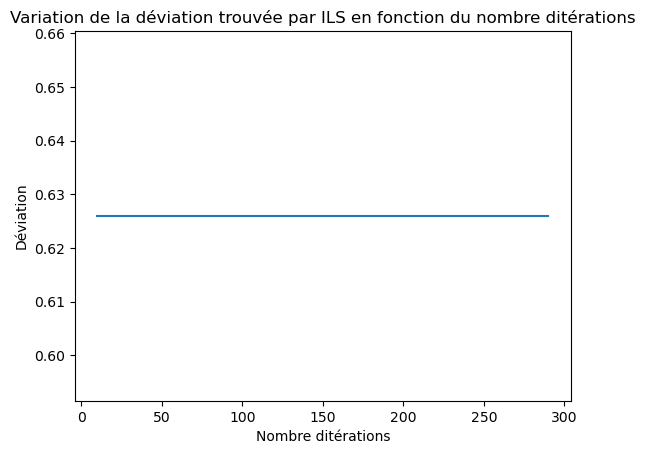

In [116]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
iter=[]
dev=[]

for max_iter in range(10,500,10):
    iter.append(max_iter)
    # schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    schedule=pso(processing_times,500,max_iter=max_iter)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### 2. La taille du swarm :

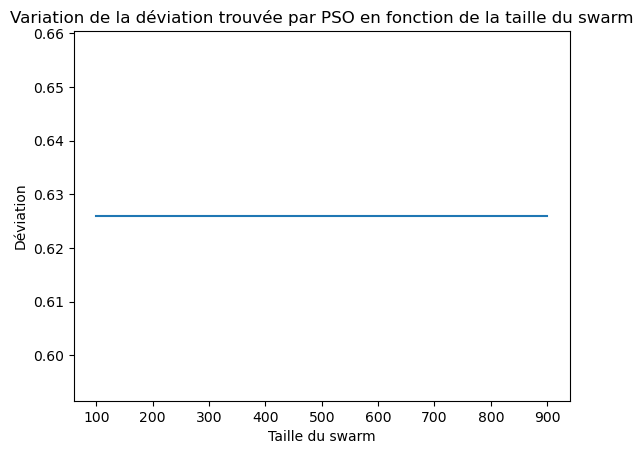

In [32]:

processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
swarm_size=[]
dev=[]

for s in range(100,1000,100):
    swarm_size.append(s)
    schedule=pso(processing_times,s,max_iter=10)
    obj=compute_makespan(schedule,processing_times)
    dev.append(100*(obj-upper_bound)/upper_bound)

# # Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(swarm_size, dev)

# Add axis labels and a title
ax.set_xlabel('Taille du swarm')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par PSO en fonction de la taille du swarm')

# Display the graph
plt.show()

### 3. 